In [10]:
from langgraph.graph import StateGraph, START, END
from typing import Dict, List, Annotated, TypedDict, Union
from IPython.display import Image, display
from tavily import TavilyClient
import json

In [27]:
# Define types for type safety
class SearchState(TypedDict):
    query: str
    basic_result: dict
    score: int
    status: str

# Initialize Tavily client
tavily_client = TavilyClient("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")

def initialize(state: SearchState):
    """Initialize the workflow and validate input."""
    print(f"Starting search for query: {state['query']}")
    return {
        "status": "initialized"
    }

def basic_search(state : SearchState):
    print("\n === Performing Basic Web Search ===")
    response = tavily_client.search(
        query = state['query'],
        search_depth = "basic",
        max_result = 1
    )
    answer = response["results"][0]
    score = response['results'][0].get("score")

    return {
        "basic_result" : answer,
        "score": score,
        "status": "search_completed"
    }

def basic_search_display(state : SearchState):
    print("\n ===== Basic Search Results =====")
    result = state['basic_result']
    print(f"Title:{result.get('title','N/A')}")
    print(f"URL:{result.get('url','N/A')}")
    print(f"Content Preview:{result.get('content','N/A')[:300]}")
    print(state['score'])

    return{
        "status": "display_complete"
    }

def router(state : SearchState):
    if state['status'] == 'initialized':
        return "basic_search"
    elif state['status'] == 'search_complete':
        return 'basic_search_display'
    elif state['status'] == 'display_complete':
        return END
    return END

In [28]:
workflow = StateGraph(SearchState)

In [29]:
workflow.add_node("initialize",initialize)
workflow.add_node("basic_search",basic_search)
workflow.add_node("basic_search_display",basic_search_display)

In [30]:
workflow.set_entry_point("initialize")

In [31]:
workflow.add_conditional_edges(
    "initialize",
    router,
    {
        "basic_search": "basic_search",
        END:END
    }
)

In [32]:
workflow.add_conditional_edges(
    "basic_search",
    router,
    {
        "basic_search_display": "basic_search_display",
        END:END
    }
)

In [33]:
workflow.add_conditional_edges(
    "basic_search_display",
    router,
    {
        END:END
    }
)

In [34]:
graph = workflow.compile()

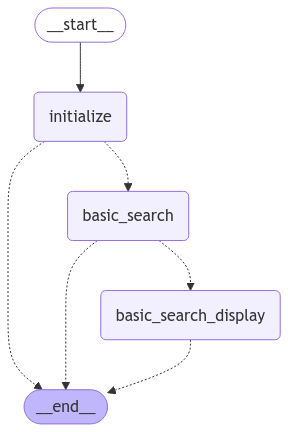

In [35]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [40]:
query = 'What is latest LLM model released Nvedia ?'

In [41]:
initial_state = SearchState(query=query, basic_result={},status='init')

In [42]:
graph.invoke(initial_state)

Starting search for query: What is latest LLM model released Nvedia ?

 === Performing Basic Web Search ===


{'query': 'What is latest LLM model released Nvedia ?',
 'basic_result': {'title': "A Walkthrough of Nvidia's Latest Multi-Modal LLM Family",
  'url': 'https://dsssolutions.com/2024/10/10/a-walkthrough-of-nvidias-latest-multi-modal-llm-family/',
  'content': 'Just last month, Nvidia released their open-source multi-modal LLM family called NVLM. The family comprises three architectures: a) decoder-based, b) cross-attention-based, and c) hybrid. The decoder-based model takes both the image and text tokens to a pre-trained LLM, such as the LLaVA model.',
  'score': 0.7750779,
  'raw_content': None},
 'score': 0.7750779,
 'status': 'search_completed'}

In [43]:
%%time
query2 = 'How to rename column name in pandas ?'
initial_state2 = SearchState(query=query2, basic_result={},status='init')

CPU times: user 7 μs, sys: 0 ns, total: 7 μs
Wall time: 11 μs


In [44]:
%%time
graph.invoke(initial_state2)

Starting search for query: How to rename column name in pandas ?

 === Performing Basic Web Search ===
CPU times: user 14.1 ms, sys: 5.21 ms, total: 19.3 ms
Wall time: 3.1 s


{'query': 'How to rename column name in pandas ?',
 'basic_result': {'title': 'How to rename columns in Pandas DataFrame - GeeksforGeeks',
  'url': 'https://www.geeksforgeeks.org/how-to-rename-columns-in-pandas-dataframe/',
  'content': 'In this article, we will see how to rename column in Pandas DataFrame. The simplest way to rename columns in a Pandas DataFrame is to use the rename() function. This method allows renaming specific columns by passing a dictionary, where keys are the old column names and values are the new column names.',
  'score': 0.91901255,
  'raw_content': None},
 'score': 0.91901255,
 'status': 'search_completed'}

## New work flow

In [50]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

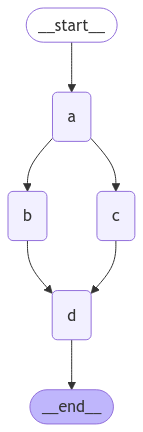

In [51]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm D"]}